In [1]:
"""
Convert building footprints to centroid and sample the image stack
"""

# Packages
import os, time, sys
from os.path import join
import geopandas as gpd
import pandas as pd
import rasterio as rio
import seaborn as sns
import gc

print(os.getcwd())
maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/earth-lab/opp-rooftop-mapping/'

# Custom functions
sys.path.append(os.getcwd())
import __functions
from __functions import *

# Coordinate Ref. System
proj = 32618  # UTM Zone 18N

print("Ready !!!")

/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/earth-lab/opp-rooftop-mapping/code
Ready !!!


In [2]:
# Sample the footprint data !!

In [4]:
# Reference data (footprints)
ref_fp = join(maindir, 'data/spatial/mod/denver_data/training/denver_data_reference_footprints.gpkg')
# Image data (see psscene-prep.ipynb)
stack_fp = join(maindir,'data/spatial/mod/denver_data/planet-data/denver_0815_psscene8b_final_norm.tif')
print(f'Reference file path: {ref_fp};\nImage file path: {stack_fp}')

Reference file path: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/earth-lab/opp-rooftop-mapping/data/spatial/mod/denver_data/training/denver_data_reference_footprints.gpkg;
Image file path: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/earth-lab/opp-rooftop-mapping/data/spatial/mod/denver_data/planet-data/denver_0815_psscene8b_final_norm.tif


In [5]:
t0 = time.time()

# Create the band stats class
band_stats_obj = BandStatistics(ref_fp, stack_fp, unique_id='uid')
# Run parallel band statistics computation
sampled = band_stats_obj.parallel_compute_stats(stat='mean')

t1 = (time.time() - t0) / 60
print(f"Total elapsed time: {t1:.2f} minutes.")
print("\n~~~~~~~~~~\n")

Raster contains 6 bands: ['nir', 'NDBIbg', 'NDBIrg', 'NISI', 'MNF1', 'NISI5x5']
Using 7 workers.
Total elapsed time: 1.82 minutes.

~~~~~~~~~~



In [9]:
sampled.head(10)

,uid,nir,NDBIbg,NDBIrg,NISI,MNF1,NISI5x5
0,78TL,-0.269367,0.761426,-0.261942,0.142143,-0.075536,1.295256
1,269TL,-0.491559,-0.228959,0.145086,-0.381386,-0.528288,1.630611
2,490TL,0.165630,0.121267,1.540670,-0.037652,-0.156279,0.792929
3,497TL,-0.163570,-0.456508,-1.066501,-1.018041,-0.692620,0.178836
4,537TL,0.124112,0.416955,0.378783,0.538502,0.390621,0.340135
5,563TL,0.095940,0.649621,0.277394,0.532190,0.383931,0.315641
6,566TL,-0.892380,0.516800,0.921309,0.149233,-0.447978,0.447005
7,573TL,-0.467032,-2.187901,1.330150,-1.622873,-1.076098,0.337933
8,736TL,0.065949,-0.988067,1.442544,-0.873170,-0.675690,0.977812
9,772TL,0.187885,-1.232693,2.927193,-0.369252,-0.488019,0.975993


In [7]:
# Merge to the original dataframe
ref = gpd.read_file(ref_fp)
ref.columns

Index(['uid', 'class_code', 'description', 'areaUTMsqft', 'lotSizeSqft',
       'geometry'],
      dtype='object')

In [8]:
sampled_ = pd.merge(ref, sampled, on='uid', how='left')
sampled_.columns

Index(['uid', 'class_code', 'description', 'areaUTMsqft', 'lotSizeSqft',
       'geometry', 'nir', 'NDBIbg', 'NDBIrg', 'NISI', 'MNF1', 'NISI5x5'],
      dtype='object')

In [8]:
gc.collect() # garbage cleanup

0

In [ ]:
# Save out the sampled data

In [10]:
# Write a csv with sampled data
out_fp = join(maindir,'data/spatial/mod/denver_data/training/denver_data_reference_footprints_sampled.gpkg')
sampled.to_csv(out_fp)
print(f'Saved sampled data table to {out_fp}')

Saved sampled data table to /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/earth-lab/opp-rooftop-mapping/data/spatial/mod/denver_data/training/denver_data_reference_footprints_sampled.gpkg


### Spectral signature plot

['uid' 'class_code' 'description' 'areaUTMsqft' 'lotSizeSqft' 'geometry'
 'nir' 'NDBIbg' 'NDBIrg' 'NISI' 'MNF1' 'NISI5x5']
['Tile' 'Wood shake/shingle' 'Concrete' 'Asphalt' 'Slate' 'Tar and gravel'
 'Composition Shingle']


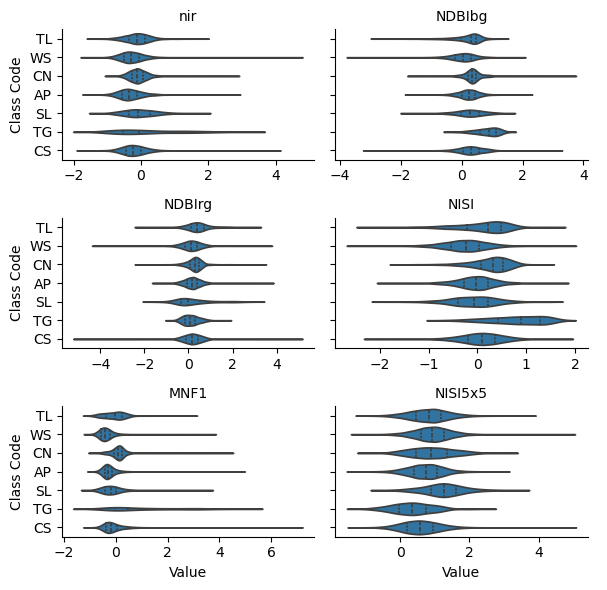

In [12]:
# Plot the distribution of abundances per material type by class
print(sampled_.columns.values)
print(sampled_['description'].unique())

new_cols = ['nir', 'NDBIbg', 'NDBIrg', 'NISI', 'MNF1', 'NISI5x5'] # removing the 27x27 texture

# Melt the DataFrame to long format
sampled_m = sampled_.melt(
    id_vars=['class_code'],
    value_vars=new_cols,
    var_name='Band',
    value_name='Value')

# Create a facet plot
g = sns.catplot(data=sampled_m, x='Value', y='class_code', col='Band',
                kind='violin', sharey=True, sharex=False, inner='quartile', 
                col_wrap=2, height=2, aspect=1.5)

# Adjusting the titles and axis labels (if needed)
g.set_titles("{col_name}")
g.set_axis_labels("Value", "Class Code")

# Save the plot


# Display the plot
plt.show()
